#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)

## 0. 데이터 불러오기

In [2]:
# 추정 매출 
buy_data = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_수정본.csv')
buy_data = buy_data.iloc[:,1:]

year_month = []
for i in range(buy_data.shape[0]):
    year_month.append(str(buy_data['기준_년_코드'].iloc[i]) + '-' + str(buy_data['기준_분기_코드'].iloc[i]))

buy_data['년-분기'] = year_month

# 대학 상권 list
college_commercial = pd.read_csv('./Data/대학인근상권.csv')
college_cm_name = list(college_commercial['TRDAR_CD_N'].unique())

# 상권 점포 데이터 
store_inf = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권점포-통합).csv', low_memory=False)

### 해당 상권의 총 점포수 확인(프랜차이즈 점포수까지 확인)
store_inf['총_점포_수'] = store_inf['점포_수'] + store_inf['프랜차이즈_점포_수']

year_month = []
for i in range(store_inf.shape[0]):
    year_month.append(str(store_inf['기준_년_코드'].iloc[i]) + '-' + str(store_inf['기준_분기_코드'].iloc[i]))

store_inf['년-분기'] = year_month

## 1. 데이터 전처리(고정) 

- [1] 추정매출 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [2] 상권점포 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [3] 상권점포 데이터 中 특정 분기에만 등장하는 상권 제거: 48개의 상권(2020-4분기)
- [4] 상권점포 데이터에서 각 상권별 서비스 업종 추출(22개 분기 모두 등장하는 업종만 추출)

In [3]:
# (1) 추정매출 데이터 내 오탈자 변경
buy_data['상권_코드_명'] = buy_data['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (2) 상권 점포 데이터 내 오탈자 변경
store_inf['상권_코드_명'] = store_inf['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (3) 상권 개수 맞춰서 진행하기
store_point_list = list(store_inf[store_inf['년-분기'] == "2016-1"]['상권_코드_명'].unique())
store_inf = store_inf.query('상권_코드_명 in @ store_point_list')

In [16]:
#(4) 상권별 - 서비스 업종이 22개 등장하는 업종만 뽑기 
find_value = (store_inf.groupby(['상권_코드','서비스_업종_코드_명'])[['기준_년_코드','기준_분기_코드']].count() == 22).reset_index()
find_value = find_value[(find_value['기준_년_코드'] == True)]

#### 22분기에 등장하는 상권-서비스 업종 대응 list
commercial_code = []
service_type_code = []
for i in find_value['상권_코드'].unique():
    commercial_code.append(i)
    value_list = []
    find_value_part = find_value[find_value['상권_코드'] == i]
    for j in find_value_part['서비스_업종_코드_명'].unique():
        value_list.append(j)
        value_list = list(set(value_list))
    service_type_code.append(value_list)
    
#### 각 상권코드를 가지고 와서 query문으로 데이터 정제
selected_data = []
for num,i in enumerate(commercial_code):  
    price_df_1 = store_inf[store_inf['상권_코드'] == i]
    find_servicetype_list = service_type_code[num]
    
    price_df_2 = price_df_1.query('서비스_업종_코드_명 in @ find_servicetype_list')    
    # 상권코드와 조합되는 서비스 업종 코드명으로 데이터 정제 후 저장
    
    selected_data.append(price_df_2)
    
data_cm = pd.concat(selected_data)
#data_cm.to_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')

store_inf = data_cm
store_inf = store_inf.reset_index(drop = True)

In [17]:
'''store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')
store_inf = store_inf.reset_indexd(drop = True)'''

"store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')\nstore_inf = store_inf.reset_indexd(drop = True)"

## 2. 데이터 Clustering 

### (1) clustring 전처리 (scatter plot도 동시에 진행)

- 업종 소분류를 상위 개념끼리 묶음화(중분류 만들기) 후 '기타'항목 제거
   
   - 음식점류 : '한식음식점','양식음식점','분식전문점','중식음식점','치킨전문점','일식음식점', '패스트푸드점'
   - 디저트류: '커피-음료' ,'제과점'
   - 소매점류: '슈퍼마켓','편의점',
   - 주점류: '호프-간이주점'
   - 오락류: '당구장','노래방','PC방'
   - 미용뷰티류: '미용실','네일숍','화장품','피부관리실'
   - 기타류: 위의 것들은 제외한 모든 소분류
     
     
- 각 상권별 평균 점포수가 특정 값(thresholo) 낮으면 해당 상권 제거: 3 기준(변경 가능한 점)

In [18]:
# (1) clustring 전처리 - 추정매출 중분류 개념 생성

print("buy_data에 서비스 업종 종류: \n{}".format(list(buy_data.서비스_업종_코드_명.unique()))) # buy_data의 서비스 업종 확인

# 중분류 정의
food_type = ['한식음식점','양식음식점','분식전문점','패스트푸드점','중식음식점','치킨전문점','일식음식점']
desert_type = ['커피-음료' ,'제과점']
market_type = ['슈퍼마켓','편의점']
drunk_type = ['호프-간이주점'] 
game_type = ['당구장','노래방','PC방','골프연습장']
bueaty_type = ['미용실','네일숍','화장품','피부관리실']

# 
buy_data['서비스_업종_중분류'] = buy_data['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')

# 기타 중분류는 분류에서 제외
data = buy_data[buy_data['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 대학상권만 가져오기
machul = data[data['상권_코드_명'].isin(college_cm_name)]
machul = machul.reset_index(drop=True)

buy_data에 서비스 업종 종류: 
['한식음식점', '편의점', '양식음식점', '분식전문점', '미용실', '제과점', '커피-음료', '한의원', '패스트푸드점', '가방', '일반의류', '슈퍼마켓', '중식음식점', '여관', '스포츠클럽', '세탁소', '당구장', '서적', '호프-간이주점', '반찬가게', '컴퓨터및주변장치판매', '시계및귀금속', '전자상거래업', '일식음식점', '치과의원', '치킨전문점', '의약품', '화초', '문구', '화장품', '핸드폰', '예술학원', '네일숍', '가구', '육류판매', '안경', '노래방', '외국어학원', '미곡판매', '자동차수리', '일반의원', '일반교습학원', '피부관리실', '조명용품', '의료기기', '인테리어', '가전제품', 'PC방', '애완동물', '스포츠 강습', '철물점', '청과상', '운동/경기용품', '섬유제품', '자동차미용', '신발', '골프연습장', '자전거 및 기타운송장비', '수산물판매', '가전제품수리', '완구', '부동산중개업', '고시원']


In [19]:
# (2) 상권별 평균 점포수 확인
check = machul.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포수', aggfunc = 'sum', 
                           fill_value = 0).sort_values(by = '2016-1')
check['평균_점포수'] = check.mean(axis = 1).round(2)

# 점포수가 적어 제거될 상권
except_cm = list(check.query('평균_점포수 <1').index)
print("점포수가 적어 제거될 상권: {}".format(except_cm))

# 해당 상권 제거
final_data = machul.query('상권_코드_명 != @except_cm').reset_index(drop=True)

print("최종 사용할 상권 수: {}개".format(len(machul['상권_코드_명'].unique())))

점포수가 적어 제거될 상권: []
최종 사용할 상권 수: 315개


#### 상권 점포 전처리
- 싱권 점포에서 추정매출과의 데이터 동일성을 위해 동일한 전처리 진행 > (1) 
- 대학 상권 vs 서울 상권의 (코로나 기간: 2020년 이후) 개/폐업률 평균 비교

In [20]:
# 각 상권마다 중분류에서 기타를 제외한 부분을 추출
store_inf['서비스_업종_중분류'] =  store_inf['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')
reduce_store_inf = store_inf[store_inf['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 상권점포-통합 데이터의 대학상권 추출
college_store_inf = reduce_store_inf .query('상권_코드_명 in @ college_cm_name')

# 추정매출간 점포수가 적었던 상권 제외 
college_store_inf = college_store_inf.query('상권_코드_명 != @except_cm').reset_index(drop=True)

display(store_inf.서비스_업종_중분류.unique())

array(['기타', '주점류', '음식점류', '디저트류', '미용뷰티류', '오락류', '마켓류'], dtype=object)

In [21]:
# 대학상권 분기별 개/폐업률 확인
college_store_cnt = college_store_inf.groupby('년-분기')['총_점포_수'].sum()         # 분기별 대학상권 점포수
college_openstore_cnt = college_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 대학상권 개업 점포 수
college_closestore_cnt = college_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 대학상권 폐업 점포 수

openstore_ratio_byquan = college_openstore_cnt / college_store_cnt * 100   # 분기별 대학상권 개업률
closestore_ratio_byquan = college_closestore_cnt / college_store_cnt  * 100 # 분기별 대학상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-1분기 이후) 평균을 구함
open_point_aftercovid = np.round(openstore_ratio_byquan.iloc[-6:].mean(), 3)  
close_point_aftercovid = np.round(closestore_ratio_byquan.iloc[-6:].mean(), 3)

display('대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid))
display('대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid))

'대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : 3.075'

'대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : 3.335'

In [22]:
# 서울상권 분기별 개/폐업률 확인
store_cnt = reduce_store_inf.groupby('년-분기')['총_점포_수'].sum()        # 분기별 서울상권 점포수
openstore_cnt = reduce_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 서울상권 개업 점포 수
closestore_cnt = reduce_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 서울상권 폐업 점포 수

openstore_ratio_byquan_seoul = openstore_cnt / store_cnt * 100   # 분기별 서울상권 개업률
closestore_ratio_byquan_seoul = closestore_cnt / store_cnt * 100 # 분기별 서울상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid_seoul = np.round(openstore_ratio_byquan_seoul.iloc[-6:].mean(), 3)  
close_point_aftercovid_seoul = np.round(closestore_ratio_byquan_seoul.iloc[-6:].mean(), 3)

display('서울상권의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid_seoul))
display('서울상권의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid_seoul))

'서울상권의 (코로나 이후) 평균 개업률 : 3.368'

'서울상권의 (코로나 이후) 평균 폐업률 : 3.409'

#### 연도별 골목상권 유형 정리 

In [23]:
store_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포_수', \
                                                aggfunc = 'sum',fill_value = 0)

openstore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '개업_점포_수', 
                                                    aggfunc = 'sum',fill_value = 0)

closestore_cnt_bycma = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '폐업_점포_수', \
                                                     aggfunc = 'sum',fill_value = 0)

openstore_ratio_bycma = openstore_cnt_bycma.div(store_cnt_bycma) * 100
closestore_ratio_bycma = closestore_cnt_bycma.div(store_cnt_bycma) * 100

#### 상권별 코로나 이후 평균 개/폐업률
openratio_bycma_aftercovid = np.round(openstore_ratio_bycma.iloc[:, -5:].mean(axis = 1),3)
closeratio_bycma_aftercovid = np.round(closestore_ratio_bycma.iloc[:, -5:].mean(axis = 1),3)

display('상권별 코로니 이후 개업률')
display(openratio_bycma_aftercovid)

display('상권별 코로니 이후 폐업률')
display(closeratio_bycma_aftercovid)

'상권별 코로니 이후 개업률'

상권_코드_명
가재울로6길     4.243
가좌로7길      4.638
갈현로1길      4.883
갈현로7길      5.885
강남시장_동작    5.000
           ...  
휘경로2길      2.772
휘경로3길      1.223
흑석로13길     2.667
흑석로9길      2.823
흑석시장       2.248
Length: 317, dtype: float64

'상권별 코로니 이후 폐업률'

상권_코드_명
가재울로6길      3.031
가좌로7길       4.239
갈현로1길       3.289
갈현로7길       2.532
강남시장_동작    10.000
            ...  
휘경로2길       3.176
휘경로3길       3.618
흑석로13길      2.657
흑석로9길       4.509
흑석시장        3.541
Length: 317, dtype: float64

In [24]:
# 상권별 군집 결과
cluster_result = pd.read_csv('상권별_군집.csv')#, encoding = 'cp949')

#### 상권별 개/폐업률(코로나 이후) - 상권의 평균 개/페업률(코로나 이후)
open_ratio = openratio_bycma_aftercovid - open_point_aftercovid
close_ratio = closeratio_bycma_aftercovid - close_point_aftercovid

value = pd.DataFrame({'개업률(%)' : open_ratio , '폐업률(%)' : close_ratio})

### segmentation 결과 합치기
value = pd.merge(value.reset_index(), cluster_result, on = '상권_코드_명', how ='inner')
value = value.set_index('상권_코드_명')
value = value[['개업률(%)','폐업률(%)','segment']].reset_index()
display(value.head())

,상권_코드_명,개업률(%),폐업률(%),segment
0,가재울로6길,1.168,-0.304,3
1,가좌로7길,1.563,0.904,2
2,갈현로1길,1.808,-0.046,8
3,갈현로7길,2.810,-0.803,3
4,강남시장_동작,1.925,6.665,9


In [ ]:
ax=X_reduce.query('label<4').groupby('label').mean().T.plot(figsize=(16, 6), cmap=plt.cm.Accent, linewidth=3, style='-', alpha=0.2)
ax=X_reduce.query('label==4').groupby('label').mean().T.plot(ax=ax, color='Red', linewidth=4, style='--', alpha=1)
# X_reduce.query('label>3').groupby('label').mean().T.plot(ax=ax, cmap=plt.cm.Accent, linewidth=3, style='-', alpha=0.2)
plt.xticks([i for i in range(len(X_reduce.columns)-1)], X_reduce.columns[:-1], rotation=20)
plt.legend(loc='upper right', title='군집')
plt.grid(alpha=0.3)
plt.title('시간에 따른 군집별 평균DF', size=20)
plt.show()

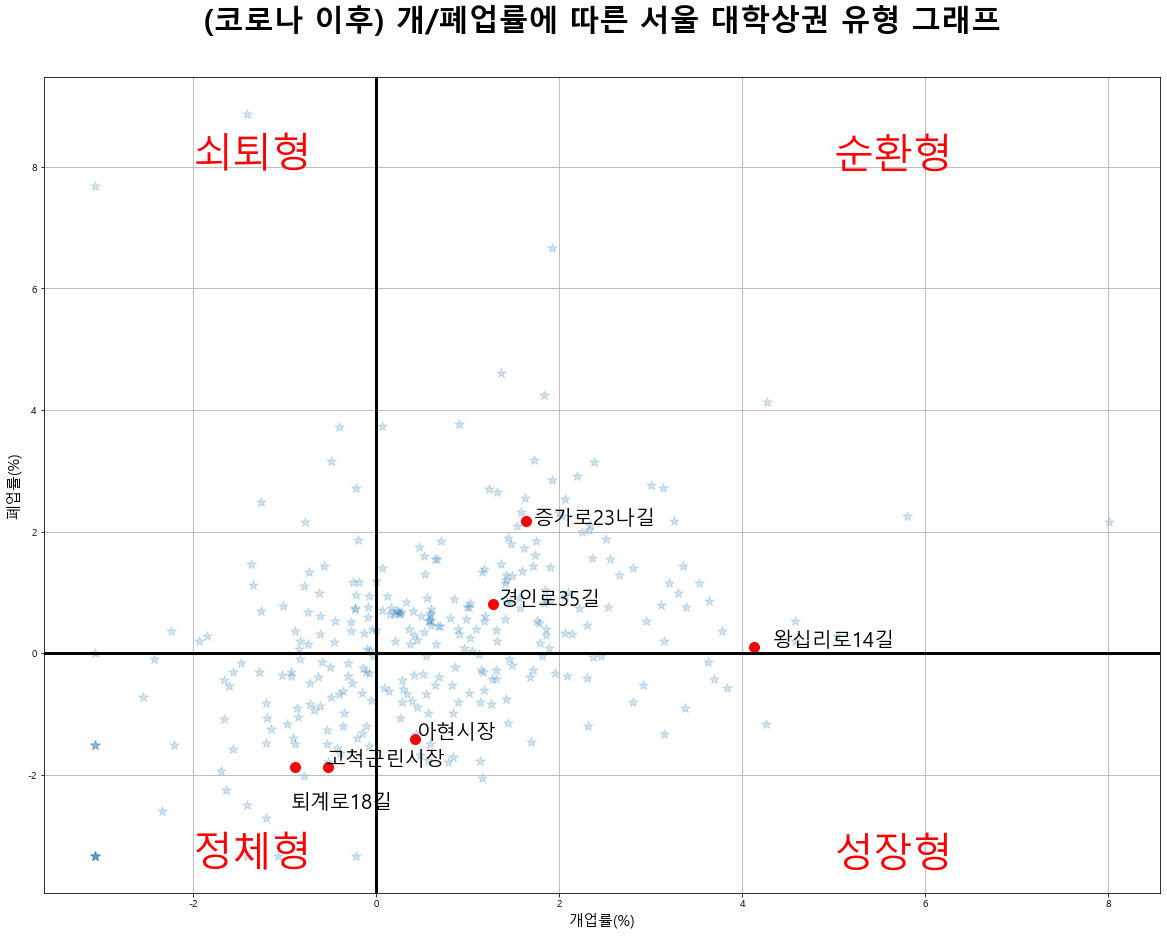

In [93]:
fig, ax = plt.subplots(figsize =(20,15))

ax.scatter(value.query('segment ==10')["개업률(%)"], value.query('segment ==10')["폐업률(%)"], 
             color = 'red' ,s = 100)
           
           
ax.scatter(value.query('segment !=10')["개업률(%)"], value.query('segment !=10')["폐업률(%)"],
           cmap=plt.cm.Accent, marker='*', alpha=0.2, s = 100)


ax.set_title("(코로나 이후) 개/폐업률에 따른 서울 대학상권 유형 그래프", 
             fontdict= {'fontsize': 30, 'fontweight':'bold'} , y=1.05)
ax.set_xlabel("개업률(%)", fontsize=15)
ax.set_ylabel("폐업률(%)", fontsize=15)
ax.grid()

# x,y축 그리기
plt.axvline(x = 0, color='black', linewidth=3)
plt.axhline(y = 0, color='black', linewidth=3)

# 사분면 정의 된거 text 표시
plt.text(5.0, 8.0, '순환형', fontsize=40, color='red')
plt.text(5.0, -3.5, '성장형', fontsize=40, color='red') 
plt.text(-2.0, -3.5, '정체형', fontsize=40, color='red') 
plt.text(-2.0, 8.0, '쇠퇴형', fontsize=40, color='red') 


for i, n in enumerate(list(value.query('segment ==10').index)[:-1]):
    plt.text(value.query('segment ==10')["개업률(%)"][n]*1.05, value.query('segment ==10')["폐업률(%)"][n]*0.98, 
             value.query('segment ==10')["상권_코드_명"][n], fontsize=20)
    
        
plt.text(value.query('segment ==10')["개업률(%)"][283]*1.05, value.query('segment ==10')["폐업률(%)"][283]* 1.35, 
             value.query('segment ==10')["상권_코드_명"][283], fontsize=20)
plt.show()

In [85]:
list(value.query('segment ==10').index)

[18, 27, 195, 213, 260, 283]

In [73]:
value.query('segment ==10')

,상권_코드_명,개업률(%),폐업률(%),segment
18,경인로35길,1.274,0.803,10
27,고척근린시장,-0.528,-1.873,10
195,아현시장,0.420,-1.420,10
213,왕십리로14길,4.131,0.107,10
260,증가로23나길,1.639,2.168,10
283,퇴계로18길,-0.886,-1.880,10


groups = value.groupby('segment')

for i, (name, group) in enumerate(groups):
    fig, ax = plt.subplots(figsize =(20,15))
    
    ax.scatter(group["개업률(%)"], group["폐업률(%)"], cmap='coolwarm', s = 100, label = name)

    ax.set_title("(코로나 이후) 개/폐업률에 따른 군집 {} 대학상권 유형 그래프".format(name), 
                 fontdict= {'fontsize': 30, 'fontweight':'bold'} , y=1.05)
    ax.set_xlabel("개업률(%)", fontsize=15)
    ax.set_ylabel("폐업률(%)", fontsize=15)
    ax.grid()
    
    # X,Y 축 고정
    ax.set_xlim([-3,4])
    ax.set_ylim([-3,4])
    
    # x,y축 그리기
    plt.axvline(x = 0, color='black', linewidth=3)
    plt.axhline(y = 0, color='black', linewidth=3)
    ax.legend(fontsize=12, loc='upper left')

    # 사분면 정의 된거 text 표시
    plt.text(3.0, 3.0, '순환형', fontsize=25, color='red')
    plt.text(3.0, -2.5, '성장형', fontsize=25, color='red') 
    plt.text(-2.0, -2.5, '정체형', fontsize=25, color='red') 
    plt.text(-2.0, 3.0, '쇠퇴형', fontsize=25, color='red') 

plt.show()